# Importação das bibliotecas necessárias

Importamos bibliotecas para manipulação de dados, pré-processamento, modelagem e visualização.


In [130]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score

# Carregamento dos dados

Arquivo CSV do histórico do Ibovespa. O arquivo utiliza vírgula tanto para separar 

In [131]:
df_ibovespa = pd.read_csv("Historico_3_Anos_Ibovespa.csv", sep=",", decimal=",")

# Criação da função para categorização da variação do dia

Se a variação percentual do dia for maior que zero, retornamos "1" (alta), caso contrário "0" (queda ou estável).


In [132]:
def categoriza_dia(df_var_dia):
    if df_var_dia > 0:
        return "1"
    else:
        return "0"

# Pré-processamento das colunas 'Vol.' e 'Var%'

Removemos o último caractere (provavelmente símbolo %), trocamos vírgula por ponto e convertemos para float para análise numérica.


In [133]:
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str[:-1]
df_ibovespa['Var%'] = df_ibovespa['Var%'].str[:-1]
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].str.replace(',', '.')
df_ibovespa['Var%'] = df_ibovespa['Var%'].str.replace(',', '.')
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].astype(float)
df_ibovespa['Var%'] = df_ibovespa['Var%'].astype(float)


# Conversão da coluna 'Data' para formato datetime

Assim, podemos trabalhar facilmente com datas e ordenar os dados cronologicamente.

In [134]:
df_ibovespa["Data"] = pd.to_datetime(df_ibovespa["Data"], format="%d.%m.%Y")

# Tratamento das colunas numéricas de preços

Removemos pontos que indicam milhares e convertendo as colunas para tipo float.

In [135]:
df_ibovespa["Último"] = df_ibovespa["Último"].str.replace(".", "").astype(float)
df_ibovespa["Abertura"] = df_ibovespa["Abertura"].str.replace(".", "").astype(float)
df_ibovespa["Máxima"] = df_ibovespa["Máxima"].str.replace(".", "").astype(float)
df_ibovespa["Mínima"] = df_ibovespa["Mínima"].str.replace(".", "").astype(float) 


# Criação das médias móveis (MM2, MM3, MM5)

Suavizam a série temporal para destacar tendências e reduzir ruído.


In [136]:
df_ibovespa['MM2'] = df_ibovespa['Último'].rolling(window=2).mean()
df_ibovespa['MM3'] = df_ibovespa['Último'].rolling(window=3).mean()
df_ibovespa['MM5'] = df_ibovespa['Último'].rolling(window=5).mean()

# Ordenação dos dados por data para garantir sequência temporal correta

In [137]:
df_ibovespa = df_ibovespa.sort_values('Data')

# Criação de variáveis lag (defasadas) para capturar dependência temporal

As variáveis representam valores do dia anterior para abertura, máxima, mínima e fechamento.


In [138]:
df_ibovespa['Abertura_d-1'] = df_ibovespa['Abertura'].shift(1)
df_ibovespa['Máxima_d-1'] = df_ibovespa['Máxima'].shift(1)
df_ibovespa['Mínima_d-1'] = df_ibovespa['Mínima'].shift(1)
df_ibovespa["Último_d-1"] = df_ibovespa["Último"].shift(1)


# Criação da variável target binária: 1 para alta, 0 para queda/estável


In [139]:
df_ibovespa["Target"] = df_ibovespa["Var%"].apply(categoriza_dia)

# Remoção de linhas com dados faltantes gerados pelos cálculos anteriores (rolling, shift)


In [140]:
df_ibovespa = df_ibovespa.dropna()

# Divisão dos dados em treino e teste

Usamos os últimos 30 dias para teste, preservando a ordem temporal para evitar vazamento de dados.


In [141]:
train = df_ibovespa.iloc[:-30]
test = df_ibovespa.iloc[-30:]


# Seleção das features e do target para treino e teste

Escolha das features baseadas em testes anteriores para evitar overfitting e manter boa performance.


In [142]:
X_train = train[["Abertura", "Abertura_d-1", "Máxima_d-1", "Mínima_d-1", "MM2", "Último_d-1"]]
y_train = train['Target'].astype(int)

X_test = test[["Abertura", "Abertura_d-1", "Máxima_d-1", "Mínima_d-1", "MM2", "Último_d-1"]]
y_test = test['Target'].astype(int)


# Normalização das features com StandardScaler

Normaliza os dados para que os algoritmos que dependem da escala funcionem melhor (ex: regressão logística).


In [143]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Definição dos modelos de Regressão Logística

Criamos dois objetos de modelo:
- `model`: para os dados originais (sem escalonamento)
- `model_scaled`: para os dados normalizados com StandardScaler


In [144]:
model = LogisticRegression()
model_scaled = LogisticRegression()


# Treinamento dos modelos

Ajustamos os modelos aos dados de treino:
- `model` usa os dados brutos
- `model_scaled` usa os dados escalonados


In [145]:
model.fit(X_train, y_train)
model_scaled.fit(X_train_scaled, y_train)



c:\Users\Igor\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


# Previsões com os dados de teste

Geramos as previsões para os dados de teste:
- `y_pred` para dados não escalonados
- `y_pred_scaled` para dados escalonados


In [146]:
y_pred = model.predict(X_test)
y_pred_scaled = model_scaled.predict(X_test_scaled)


# Avaliação da acurácia dos modelos

Calculamos e exibimos a acurácia dos dois modelos para comparar performance.


In [147]:
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.2f} ({acc*100:.1f}%)")

acc_scaled = accuracy_score(y_test, y_pred_scaled)
print(f"Acurácia_scaled: {acc_scaled:.2f} ({acc_scaled*100:.1f}%)")


Acurácia: 0.80 (80.0%)
Acurácia_scaled: 0.83 (83.3%)


# Relatórios detalhados de classificação

Exibimos métricas detalhadas (precisão, recall, f1-score) para cada classe (queda e alta).


In [148]:
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=["Queda (0)", "Alta (1)"]))

print("Relatório de Classificação (Escalonado):")
print(classification_report(y_test, y_pred_scaled, target_names=["Queda (0)", "Alta (1)"]))


Relatório de Classificação:
              precision    recall  f1-score   support

   Queda (0)       0.88      0.78      0.82        18
    Alta (1)       0.71      0.83      0.77        12

    accuracy                           0.80        30
   macro avg       0.79      0.81      0.80        30
weighted avg       0.81      0.80      0.80        30

Relatório de Classificação (Escalonado):
              precision    recall  f1-score   support

   Queda (0)       0.88      0.83      0.86        18
    Alta (1)       0.77      0.83      0.80        12

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



# Matriz de Confusão para o modelo com dados originais

Visualização da matriz de confusão para entender erros de classificação.


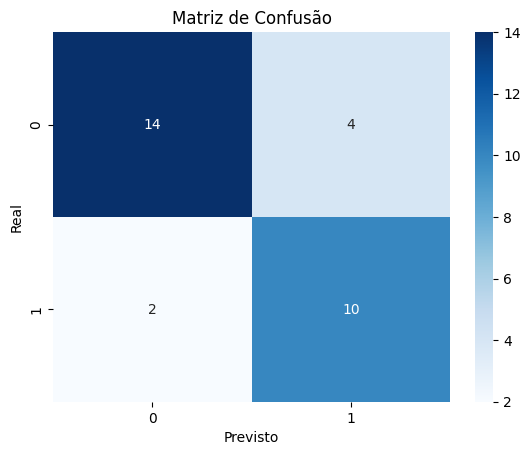

In [149]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()


# Matriz de Confusão para o modelo com dados escalonados

Visualização da matriz de confusão para o modelo que usou dados normalizados.


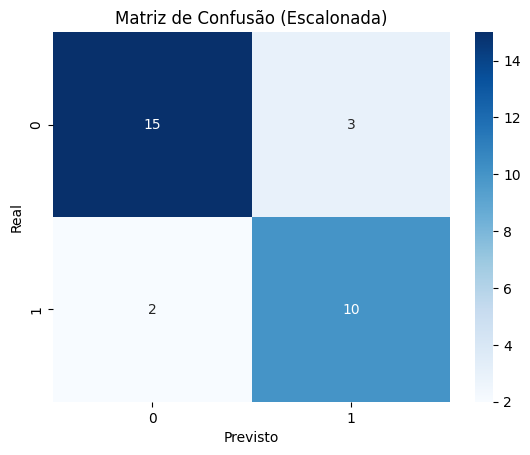

In [150]:
cm_scaled = confusion_matrix(y_test, y_pred_scaled)
sns.heatmap(cm_scaled, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão (Escalonada)')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()


# Modelo Random Forest (sem escalonamento)

Vamos treinar e avaliar um modelo Random Forest utilizando:
- Cross-validation com validação temporal (TimeSeriesSplit)
- Treinamento completo com o conjunto de treino
- Avaliação no conjunto de teste (últimos 30 dias)

## Criação do modelo Random Forest

Usamos:
- `n_estimators=100`: número de árvores na floresta
- `max_depth=4`: profundidade máxima das árvores (controle de overfitting)
- `random_state=42`: para garantir reprodutibilidade


# Seleção das features e do target para treino e teste Modelo Random Forest

Escolha das features baseadas em testes anteriores para evitar overfitting e manter boa performance.

In [151]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

# Seleção das features e do target para treino e teste

Escolha das features 

In [152]:
X_train_random = train[["Abertura", "Abertura_d-1", "Máxima_d-1", "Mínima_d-1", "MM2","MM3","MM5", "Último_d-1"]]
y_train_random = train['Target'].astype(int)

X_test_random = test[["Abertura", "Abertura_d-1", "Máxima_d-1", "Mínima_d-1", "MM2","MM3","MM5", "Último_d-1"]]
y_test_random = test['Target'].astype(int)

# Teinando modelo

In [153]:
rf_model.fit(X_train_random, y_train_random)

,n_estimators,100
,criterion,'gini'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Validação Cruzada com séries temporais

Utilizamos `TimeSeriesSplit` para garantir que os dados futuros nunca influenciem o treinamento.


In [154]:
tscv = TimeSeriesSplit(n_splits=5)

## 🔍 Importância das Variáveis no Random Forest

O Random Forest calcula automaticamente a importância de cada variável com base em sua contribuição para reduzir a impureza nas decisões. Essa visualização ajuda a entender quais variáveis realmente influenciam as previsões.

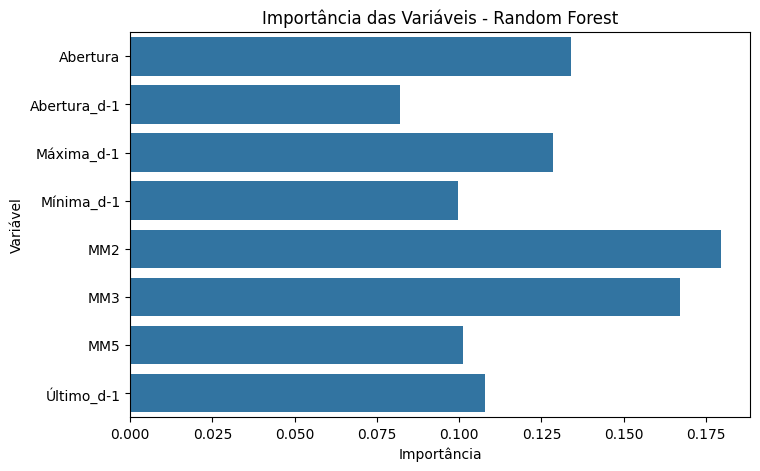

In [155]:
# Extrai as importâncias das variáveis RF
importances = rf_model.feature_importances_
features = X_train_random.columns

# Visualiza em um gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("Importância das Variáveis - Random Forest")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.show()


## 🔍 Atualizando variaveis

Verificando quais variaveis com base na contribuição 

In [156]:
X_train_random = train[["Abertura", "Máxima_d-1", "MM2","MM3", "Último_d-1"]]
y_train_random = train['Target'].astype(int)

X_test_random = test[["Abertura", "Máxima_d-1", "MM2","MM3", "Último_d-1"]]
y_test_random = test['Target'].astype(int)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

## Treinamento do modelo com todos os dados de treino

Agora usamos o treino completo para treinar o modelo final random.

In [157]:
rf_model.fit(X_train_random, y_train_random)

,n_estimators,100
,criterion,'gini'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Validação Cruzada com séries temporais

Utilizamos `TimeSeriesSplit` para garantir que os dados futuros nunca influenciem o treinamento.


In [158]:
tscv = TimeSeriesSplit(n_splits=5)

## Cross-Validation no conjunto de treino (sem escalonamento)

Usamos 5 divisões com validação temporal para medir a estabilidade do modelo.


In [159]:
cv_scores = cross_val_score(rf_model, X_train_random, y_train_random, cv=tscv, scoring='accuracy')
print(f"\n📊 Cross-Validation (5-folds) - Média de acurácia no treino: {cv_scores.mean():.2f} ({cv_scores.mean()*100:.1f}%)")



📊 Cross-Validation (5-folds) - Média de acurácia no treino: 0.62 (62.2%)


## Previsão e Avaliação no conjunto de teste

Avaliamos o modelo com os últimos 30 dias (dados não vistos durante o treino).

In [160]:
y_pred_rf = rf_model.predict(X_test_random)

acc_rf = accuracy_score(y_test_random, y_pred_rf)
print(f"\n🎯 Acurácia no conjunto de teste (últimos 30 dias): {acc_rf:.2f} ({acc_rf*100:.1f}%)")

print("\nRelatório de Classificação (Random Forest):")
print(classification_report(y_test_random, y_pred_rf, target_names=["Queda (0)", "Alta (1)"]))



🎯 Acurácia no conjunto de teste (últimos 30 dias): 0.40 (40.0%)

Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

   Queda (0)       0.00      0.00      0.00        18
    Alta (1)       0.40      1.00      0.57        12

    accuracy                           0.40        30
   macro avg       0.20      0.50      0.29        30
weighted avg       0.16      0.40      0.23        30



c:\Users\Igor\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Igor\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Igor\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

## 📈 Curva ROC (Receiver Operating Characteristic)

A curva ROC mostra a capacidade do modelo em distinguir entre classes (Alta vs. Queda). A AUC (Área sob a Curva) indica o quão bem o modelo separa as classes: quanto mais próximo de 1, melhor.


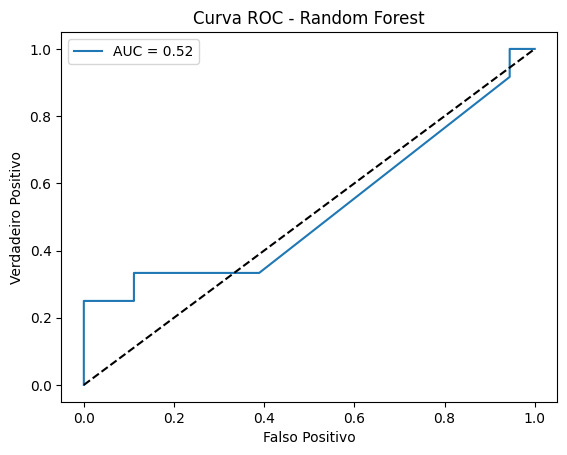

In [161]:

# Probabilidades da classe positiva
y_proba_rf = rf_model.predict_proba(X_test_random)[:, 1]

# Curva ROC
fpr, tpr, _ = roc_curve(y_test_random, y_proba_rf)
auc = roc_auc_score(y_test_random, y_proba_rf)

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.show()

## 📌 Considerações Finais

A **Regressão Logística** apresentou o melhor desempenho, com **83% de acurácia**, mesmo sendo um modelo estatisticamente mais simples. Seu bom resultado se deve à:

- **Baixa tendência ao overfitting**  
- Boa **capacidade de generalização**, especialmente com dados limitados  
- Relações mais lineares entre as variáveis

Por outro lado, o **Random Forest**, mesmo sendo mais robusto, teve uma acurácia bem inferior (**~40%**), o que pode ser atribuído a:

- Uso de apenas **30 dias como teste**, o que aumenta a influência de ruídos e eventos atípicos  
- **Underfitting**, devido à profundidade limitada do modelo (`max_depth=4`)  
- Dificuldade em **generalizar padrões históricos** com pouco volume de dados

---

### ✅ Conclusão

A **Regressão Logística se mostrou mais eficaz e confiável** neste cenário, superando o Random Forest graças à sua simplicidade, estabilidade e melhor adaptação ao volume e qualidade dos dados disponíveis.
